<a href="https://colab.research.google.com/github/astro-blue/Data-analysis-in-astronomy-2022/blob/main/week_15/HW6_CNN_vs_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data analysis in Astronomy 
### HW6 Classifition of digits
### Deadline 12/27 23:59 
### Your name:

### Again, print out your code and the results and the final plot into pdf. 
### Challenge: build a CNN model to classify images with digits and obtain the final accuracy for the test dataset > 0.9912 (the record we get from the kernel SVM)


If your model can obtain the accuracy of the test dataset >0.9912, you get 100/100.

If you model can obtain the accuracy of the test dataset between 0.99 and 0.9912, you get 90/100. 

If you model can obtain the accuracy of the test dataset between 0.985 and 0.99, you get 80/100.

You have to at least get >0.985 in order to get the points. But, it should not be difficult. (It took me ~15 mins to find a model that can do 0.997 accuracy of the test data.)

### This is a bonus HW. 如果你有交，這份作業成績會用來取代之前分數最低的作業。(不包含之前要你們問問題/寫心得那份)

Have fun!



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"

import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.transform import rotate

Mounted at /content/gdrive


In [ ]:
'''A function to convert the image data into Pytorch tensor matrix'''

def give_me_Pytorch_data_form(input_image, input_labels,torch_format=True):
    whole_length = len(input_image[0])
    width = int(np.sqrt(whole_length))
    image_matrix = np.zeros((len(input_image),1,width,width))
    labels_matrix = np.zeros((len(input_image),10))
    for i in range(0,len(input_image)):
        image_matrix[i,0,:,:]=input_image[i].reshape(width,width)
        labels_matrix[i,input_labels[i]]=1.
    
    if torch_format==True:
        image_matrix = torch.from_numpy(np.array(image_matrix,dtype=np.float32))
        labels_matrix = torch.from_numpy(np.array(labels_matrix,dtype=np.float32))

    return image_matrix,labels_matrix

Training data https://drive.google.com/file/d/1UQufnFEJFpJR3-fFjImm_oXVTsSJ5KrA/view?usp=sharing

Test data https://drive.google.com/file/d/1r2yuYPKoY386PqWfz8rf-JsmgE4_lmHt/view?usp=sharing

In [ ]:
train = pf.open(root_dir+'Training.fits')
test = pf.open(root_dir+'Test.fits')

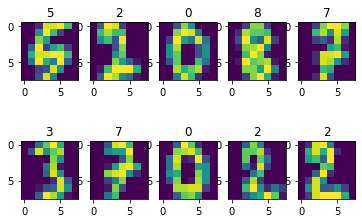

In [ ]:
for i in range(0,10):
    plt.subplot(2,5,i+1)
    plt.imshow(train[0].data[i].reshape(8,8))
    plt.title(train[1].data[i])

In [ ]:
'''Converting original data into Pytorch data'''
image_train, image_labels = give_me_Pytorch_data_form(train[0].data,train[1].data,torch_format=True)
image_test, test_labels = give_me_Pytorch_data_form(test[0].data,test[1].data)

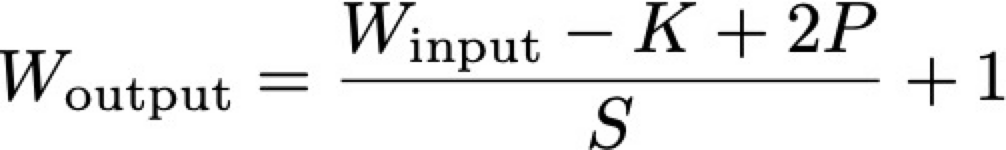

In [ ]:
'''A simple CNN architecture'''
'''You need to upgrade it to get better performance'''


class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ### 
        ### input 1x8x8 
        self.cnn1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8,kernel_size=3,padding=1,stride=1), #8x8x8
            torch.nn.BatchNorm2d(8),
            #torch.nn.MaxPool2d(kernel_size=2), #20x4x4
            torch.nn.ReLU(),
            )
 
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(512, 10))
              
        #self.fc2 = torch.nn.Linear(10, 10)
    def forward(self, x):
        x = self.cnn1(x)
        x = x.view(x.size(0), -1)
        #x = self.fc1(x)
        x = self.fc1(x)
        out = x
        return out

In [ ]:
model = CNN()

In [ ]:
learningRate = 0.01
epochs = 100
criterion = torch.nn.CrossEntropyLoss()
# Just the loss function : here we use the default CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [ ]:
accuracy_array = []
accuracy_test_array = []
loss_array = []
loss_test_array = []
epoch_array = []
N_total_train = len(image_train)
batch_size=64
for epoch in range(epochs):
    
    model.train() # here is to tell the code to do the training again after model.eval() mode
    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    for start_index_batch in range(0,N_total_train,batch_size):
        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()
        end_index = min(start_index_batch + batch_size, N_total_train)
        # get output from the model, given the inputs
        #print(len(color_train[start_index_batch:end_index,:]))
        outputs = model(image_train[start_index_batch:end_index])
        
        # get loss for the predicted output
        loss = criterion(outputs, image_labels[start_index_batch:end_index,:])
        # get gradients w.r.t to parameters
        loss.backward()
        # update parameters
        optimizer.step()
        
    model.eval() # here is to fix the parameters (mean, sigma) of the batchnormalization, given that the batchnorm calculates the mean sigma with a new batch everytime during training. 
    with torch.no_grad():   
        outputs_all = model(image_train)
        pred_y = torch.max(outputs_all, 1)[1].data.squeeze()
        accuracy = torch.sum((pred_y == torch.max(image_labels, 1)[1].data.squeeze()) / pred_y.size(0))
        epoch_array.append(epoch)

        loss_array.append(float(loss.detach().numpy()))
        accuracy_array.append(float(accuracy.numpy()))


        outputs_test = model(image_test) 
        loss_test = criterion(outputs_test, test_labels)

        pred_y_test = torch.max(outputs_test, 1)[1].data.squeeze()
        accuracy_test = torch.sum((pred_y_test == torch.max(test_labels, 1)[1].data.squeeze()) / pred_y_test.size(0))
        accuracy_test_array.append(float(accuracy_test.numpy()))
        loss_test_array.append(float(loss_test.detach().numpy()))

    if epoch % 1 ==0:
        print(epoch,accuracy.numpy(),loss.detach().numpy(), accuracy_test.numpy(),loss_test.detach().numpy())

0 0.6072754 1.6826115 0.57111114 1.6773646
1 0.8158873 1.1466123 0.82666653 1.2031015
2 0.87527853 0.79393095 0.8844443 0.89090145
3 0.902747 0.5651416 0.9 0.6962464
4 0.9175948 0.42130074 0.9133332 0.57069397
5 0.9279883 0.32820457 0.91777766 0.48518756
6 0.9376393 0.26528946 0.9222221 0.423982
7 0.9458056 0.22119105 0.931111 0.37775007
8 0.9495176 0.18941282 0.93555546 0.34153643
9 0.9524871 0.16538396 0.9399999 0.31269386
10 0.95322955 0.14668244 0.9422221 0.2890556
11 0.95545673 0.13163607 0.9444443 0.26927915
12 0.9569415 0.1193763 0.9555553 0.25250152
13 0.95991105 0.10906702 0.9555553 0.23793742
14 0.96213824 0.10033416 0.9577776 0.22553734
15 0.96362305 0.09276744 0.96222204 0.2144988
16 0.96510786 0.08623918 0.9644443 0.20487179
17 0.96585023 0.080517285 0.9644443 0.196247
18 0.96733505 0.0754733 0.9644443 0.18853575
19 0.9688198 0.07103651 0.9644443 0.18154182
20 0.9703046 0.06704261 0.96666646 0.17520769
21 0.97253174 0.063474566 0.96666646 0.16947232
22 0.97401655 0.0602353

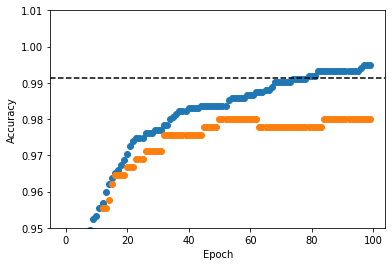

In [ ]:
plt.scatter(epoch_array,accuracy_array,color='C0')
plt.scatter(epoch_array,accuracy_test_array,color='C1')
plt.ylim(0.95,1.01)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axhline(0.9912,ls='--',color='black')

The accuracy of the test dataset needs to be higher than the black dashed line.